# Training

## Import Data | Split into Train/Test

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

data = pd.read_csv("FuelEconomy.csv")
data.head()

X = data['Horse Power']
y = data['Fuel Economy (MPG)']

X = np.array(X).astype('float32')
y = np.array(y).astype('float32')

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30)

## Import AWS SDK via Boto3 | Retrieve Sagemaker Execution Role

In [31]:
import sagemaker
import boto3

sagemaker_session = sagemaker.Session()

bucket = 'jingle-projects'
prefix = 'linear_learner'

role = sagemaker.get_execution_role()
print(role)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
arn:aws:iam::809503251832:role/AWS_Sagemaker_Full_Access


## Convert Train Data to RecordIO

In [32]:
import io
import numpy as np
import sagemaker.amazon.common as smac

X_train = X_train.reshape(-1, 1)

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, X_train, y_train)
buf.seek(0) 

0

## Upload Training Data to S3 for Training

In [33]:
import os

key = 'mpg-train-data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://jingle-projects/linear_learner/train/mpg-train-data


## Convert Test Data to RecordIO

In [37]:
X_test = X_test.reshape(-1, 1)
y_test = y_test.astype('float32')

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, X_test, y_test)
buf.seek(0) 

0

## Upload Test Data to S3 for Training

In [38]:
key = 'linear-test-data'

boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test', key)).upload_fileobj(buf)

s3_test_data = 's3://{}/{}/test/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_test_data))

uploaded training data location: s3://jingle-projects/linear_learner/test/linear-test-data


## Placeholder to Store Model Output

In [39]:
output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

Training artifacts will be uploaded to: s3://jingle-projects/linear_learner/output


## Retrieve the training container for the LinearLearner algorithm

In [46]:
container = sagemaker.image_uris.retrieve("linear-learner", boto3.Session().region_name)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


## Create the estimator object and sets hyperparameters

In [47]:
linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       instance_count = 1, 
                                       instance_type = 'ml.m4.xlarge',
                                       output_path = output_location,
                                       sagemaker_session = sagemaker_session,
                                       use_spot_instances=True,
                                       max_run = 60,
                                       max_wait = 120)

linear.set_hyperparameters(feature_dim = 1,
                           predictor_type = 'regressor',
                           mini_batch_size = 5,
                           epochs = 5,
                           num_models = 32,
                           loss = 'absolute_loss')

## Train the Model!

In [48]:
linear.fit({'train': s3_train_data})

INFO:sagemaker:Creating training-job with name: linear-learner-2023-11-20-19-46-17-193


2023-11-20 19:46:17 Starting - Starting the training job......
2023-11-20 19:46:54 Starting - Preparing the instances for training......
2023-11-20 19:47:57 Downloading - Downloading input data...
2023-11-20 19:48:27 Training - Downloading the training image......
2023-11-20 19:49:43 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/20/2023 19:50:03 INFO 140698178795328] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss

# Deployment

## Import Libraries for reading data from an endpoint | Load endpoint

In [49]:
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import CSVSerializer

linear_regressor = linear.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m4.xlarge',
                                 serializer = CSVSerializer(),
                                 deserializer = JSONDeserializer())

INFO:sagemaker:Creating model with name: linear-learner-2023-11-20-19-52-24-113
INFO:sagemaker:Creating endpoint-config with name linear-learner-2023-11-20-19-52-24-113
INFO:sagemaker:Creating endpoint with name linear-learner-2023-11-20-19-52-24-113


---------!

In [50]:
result = linear_regressor.predict(X_test)

In [51]:
predictions = np.array([r['score'] for r in result['predictions']])

In [52]:
predictions

array([20.16510963, 24.27571869, 21.75017166, 14.85158157, 20.89558029,
       25.13499069, 23.45093536, 30.36515427, 18.2617054 , 25.79453087,
       21.67390442, 24.11321831, 21.82940483, 16.62739182, 29.54484558,
       24.97338486, 20.39742088, 25.77175903, 27.14259911, 26.74954987,
       21.34647369, 16.84538269, 20.94968224, 27.34369278, 23.98570061,
       25.83585167, 17.59520721, 21.23316574, 19.83618546, 18.65232468])

In [53]:
import matplotlib.pyplot as plt

INFO:matplotlib.font_manager:generated new fontManager


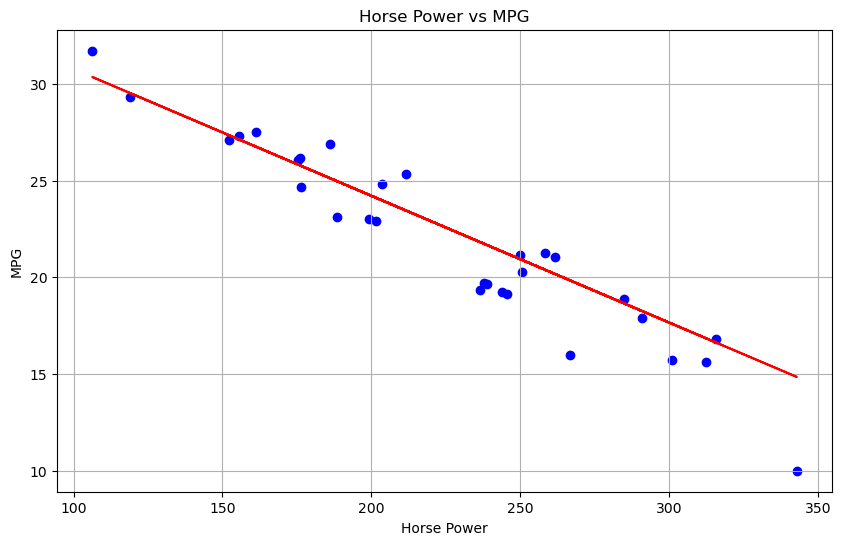

In [54]:
# VISUALIZE TEST SET RESULTS
plt.figure(figsize = (10, 6))
plt.scatter(X_test, y_test, color = 'blue')
plt.plot(X_test, predictions, color = 'red')
plt.xlabel('Horse Power')
plt.ylabel('MPG')
plt.title('Horse Power vs MPG')
plt.grid()

## Delete Endpoint! Or else you will be billed!

In [55]:
linear_regressor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: linear-learner-2023-11-20-19-52-24-113
INFO:sagemaker:Deleting endpoint with name: linear-learner-2023-11-20-19-52-24-113
